In [1]:
# 파이썬 ≥3.5 필수 (파이썬 3.7 추천)
import sys
assert sys.version_info >= (3, 5) 

# 사이킷런 ≥0.20 필수
import sklearn
assert sklearn.__version__ >= "0.20"

# 공통 모듈 임포트
import numpy as np
import os

# 노트북 실행 결과를 동일하게 유지하기 위해
np.random.seed(42)

# 깔끔한 그래프 출력을 위해
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)

# 그림 저장 위치 지정
PROJECT_ROOT_DIR = "."
CHAPTER_ID = "dim_reduction"
IMAGES_PATH = os.path.join(PROJECT_ROOT_DIR, "images", CHAPTER_ID)
os.makedirs(IMAGES_PATH, exist_ok=True)

def save_fig(fig_id, tight_layout=True, fig_extension="png", resolution=300):
    path = os.path.join(IMAGES_PATH, fig_id + "." + fig_extension)
    print("Saving figure", fig_id)
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format=fig_extension, dpi=resolution)

## 8.2 차원축소 기법 소개
### 8.2.1 사영 기법

In [3]:
np.random.seed(4)

m = 60
noise = 0.1

X = np.empty((m, 3))

angles = np.random.rand(m) * 3 * np.pi / 2 - 0.5
X[:, 0] = np.cos(angles) + np.sin(angles) / 2 + noise * np.random.randn(m) / 2
X[:, 1] = np.sin(angles) * 0.7 + noise * np.random.randn(m) / 2

w1, w2 = 0.1, 0.3
X[:, 2] = X[:, 0] * w1 + X[:, 1] * w2 + noise * np.random.randn(m)


In [4]:
X_centered = X - X.mean(axis=0)

In [7]:
U, s, Vt = np.linalg.svd(X_centered)

In [8]:
U.shape

(60, 60)

In [9]:
s.shape

(3,)

In [13]:
Vt

array([[ 0.93636116,  0.29854881,  0.18465208],
       [-0.34027485,  0.90119108,  0.2684542 ],
       [-0.08626012, -0.31420255,  0.94542898]])

In [10]:
Vt.shape

(3, 3)

In [11]:
S = np.zeros(X_centered.shape)
S[:3, :3] = np.diag(s)
S

array([[6.77645005, 0.        , 0.        ],
       [0.        , 2.82403671, 0.        ],
       [0.        , 0.        , 0.78116597],
       [0.        , 0.        , 0.        ],
       [0.        , 0.        , 0.        ],
       [0.        , 0.        , 0.        ],
       [0.        , 0.        , 0.        ],
       [0.        , 0.        , 0.        ],
       [0.        , 0.        , 0.        ],
       [0.        , 0.        , 0.        ],
       [0.        , 0.        , 0.        ],
       [0.        , 0.        , 0.        ],
       [0.        , 0.        , 0.        ],
       [0.        , 0.        , 0.        ],
       [0.        , 0.        , 0.        ],
       [0.        , 0.        , 0.        ],
       [0.        , 0.        , 0.        ],
       [0.        , 0.        , 0.        ],
       [0.        , 0.        , 0.        ],
       [0.        , 0.        , 0.        ],
       [0.        , 0.        , 0.        ],
       [0.        , 0.        , 0.        ],
       [0.

In [12]:
np.allclose(X_centered, U.dot(S).dot(Vt))

True

In [14]:
W2 = Vt.T[:, :2]
X2D = X_centered.dot(W2)

In [15]:
X2d_using_svd = X2D

In [16]:
from sklearn.decomposition import PCA

pca = PCA(n_components=2)
X2D = pca.fit_transform(X)

In [17]:
X2D.mean(0)

array([2.96059473e-17, 2.77555756e-18])

In [18]:
np.allclose(X2D, X2d_using_svd)

False

In [19]:
np.allclose(X2D, -X2d_using_svd)

True

In [20]:
pca.components_

array([[-0.93636116, -0.29854881, -0.18465208],
       [ 0.34027485, -0.90119108, -0.2684542 ]])

In [21]:
Vt[:2]

array([[ 0.93636116,  0.29854881,  0.18465208],
       [-0.34027485,  0.90119108,  0.2684542 ]])

In [22]:
np.allclose(pca.components_, -Vt[:2])

True

In [23]:
X3D_inv = pca.inverse_transform(X2D)

In [24]:
np.allclose(X3D_inv, X)

False

In [25]:
np.mean(np.sum(np.square(X3D_inv - X), axis=1))

0.010170337792848549

In [26]:
X3D_inv_using_svd = X2d_using_svd.dot(Vt[:2, :])

In [27]:
X.mean(0)

array([0.02406745, 0.20932515, 0.07155422])

In [28]:
pca.mean_

array([0.02406745, 0.20932515, 0.07155422])

In [29]:
np.allclose(X3D_inv_using_svd, X3D_inv - pca.mean_)

True

In [30]:
pca.explained_variance_ratio_

array([0.84248607, 0.14631839])

In [31]:
1 - pca.explained_variance_ratio_.sum()

0.011195535570688975

In [32]:
np.square(s) / np.square(s).sum()

array([0.84248607, 0.14631839, 0.01119554])

In [48]:
from matplotlib.patches import FancyArrowPatch
from mpl_toolkits.mplot3d import proj3d

class Arrow3D(FancyArrowPatch):
    def __init__(self, xs, ys, zs, *args, **kwargs):
        FancyArrowPatch.__init__(self, (0,0), (0,0), *args, **kwargs)
        self._verts3d = xs, ys, zs

    def draw(self, renderer):
        xs3d, ys3d, zs3d = self._verts3d
        xs, ys, zs = proj3d.proj_transform(xs3d, ys3d, zs3d, renderer.M)
        self.set_positions((xs[0],ys[0]),(xs[1],ys[1]))
        FancyArrowPatch.draw(self, renderer)

In [49]:
axes = [-1.8, 1.8, -1.3, 1.3, -1.0, 1.0]

x1s = np.linspace(axes[0], axes[1], 10)
x2s = np.linspace(axes[2], axes[3], 10)
x1, x2 = np.meshgrid(x1s, x2s)

C = pca.components_
R = C.T.dot(C)
z = (R[0, 2] * x1 + R[1, 2] * x2) / (1 - R[2,2])

In [50]:
R

array([[ 0.99255919, -0.02710315,  0.08155282],
       [-0.02710315,  0.90127676,  0.29705619],
       [ 0.08155282,  0.29705619,  0.10616405]])

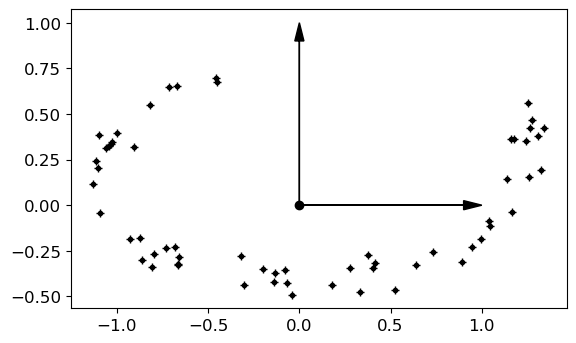

In [57]:
fig = plt.figure()
ax = fig.add_subplot(111, aspect='equal')

ax.plot(X2D[:, 0], X2D[:, 1], 'k+')
ax.plot(X2D[:, 0], X2D[:, 1], 'k.')
ax.plot([0], [0], 'ko')
ax.arrow(0, 0, 0, 1, head_width=0.05, length_includes_head=True, head_length=0.1, fc='k', ec='k')
ax.arrow(0, 0, 1, 0, head_width=0.05, length_includes_head=True, head_length=0.1, fc='k', ec='k')

In [58]:
from sklearn.datasets import make_swiss_roll
X, t = make_swiss_roll(n_samples=1000, noise=0.2, random_state=42)

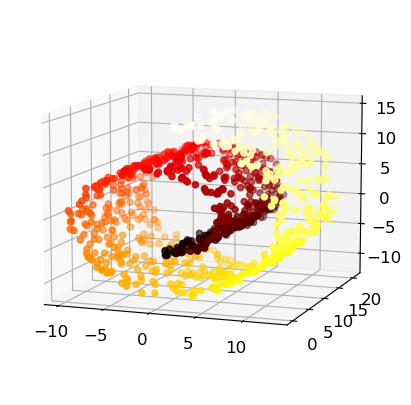

In [61]:
axes = [-11.5, 14, -2, 23, -12, 15]

fig = plt.figure(figsize=(6, 5))
ax = fig.add_subplot(111, projection='3d')

ax.scatter(X[:, 0], X[:, 1], X[:, 2], c=t, cmap=plt.cm.hot)

ax.view_init(10, -70)

(-11.5, 14.0, -2.0, 23.0)

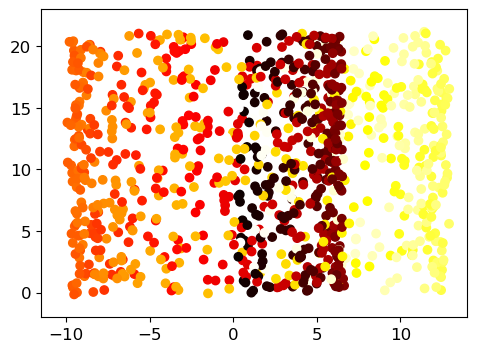

In [62]:
fig = plt.figure(figsize=(5.5, 4))

ax = fig.add_subplot(111)
ax.scatter(X[:, 0], X[:, 1], c=t, cmap=plt.cm.hot)
ax.axis(axes[:4])

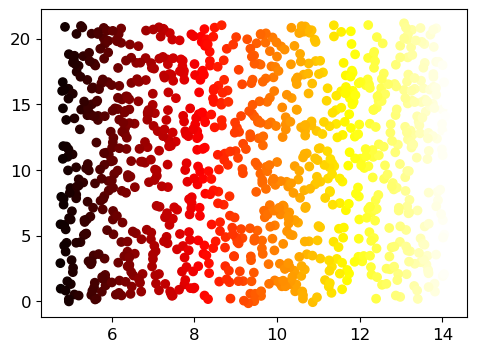

In [63]:
fig = plt.figure(figsize=(5.5, 4))

ax = fig.add_subplot(111)
ax.scatter(t, X[:, 1], c=t, cmap=plt.cm.hot)

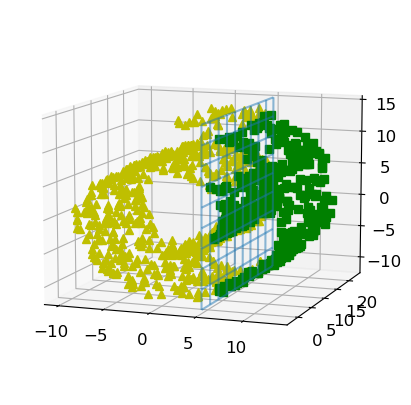

In [69]:
axes = [-11.5, 14, -2, 23, -12, 15]

x2s = np.linspace(axes[2], axes[3], 10)
x3s = np.linspace(axes[4], axes[5], 10)
x2, x3 = np.meshgrid(x2s, x3s)

fig = plt.figure(figsize=(6, 5))
ax = plt.subplot(111, projection='3d')

positive_class = X[:, 0] > 5
X_pos = X[positive_class]
X_neg = X[~positive_class]
ax.view_init(10, -70)
ax.plot(X_neg[:, 0], X_neg[:, 1], X_neg[:, 2], 'y^')
ax.plot_wireframe(5, x2, x3, alpha=0.5)
ax.plot(X_pos[:, 0], X_pos[:, 1], X_pos[:, 2], 'gs')

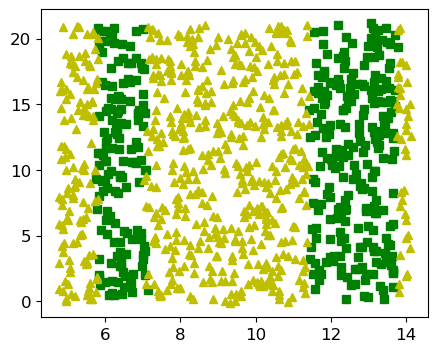

In [72]:
fig = plt.figure(figsize=(5, 4))
ax = plt.subplot(111)

plt.plot(t[positive_class], X[positive_class, 1], 'gs')
plt.plot(t[~positive_class], X[~positive_class, 1], 'y^')

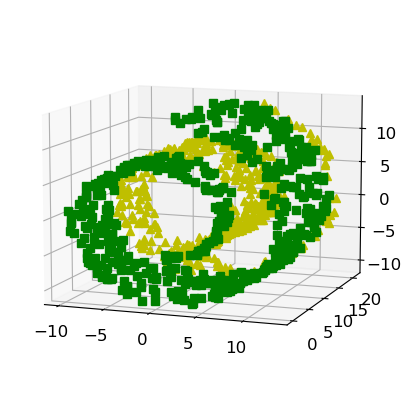

In [76]:
axes = [-11.5, 14, -2, 23, -12, 15]

x2s = np.linspace(axes[2], axes[3], 10)
x3s = np.linspace(axes[4], axes[5], 10)
x2, x3 = np.meshgrid(x2s, x3s)

fig = plt.figure(figsize=(6, 5))
ax = plt.subplot(111, projection='3d')

positive_class = 2 * (t[:] - 4) > X[:, 1]
X_pos = X[positive_class]
X_neg = X[~positive_class]
ax.view_init(10, -70)
ax.plot(X_neg[:, 0], X_neg[:, 1], X_neg[:, 2], 'y^')
ax.plot(X_pos[:, 0], X_pos[:, 1], X_pos[:, 2], 'gs')

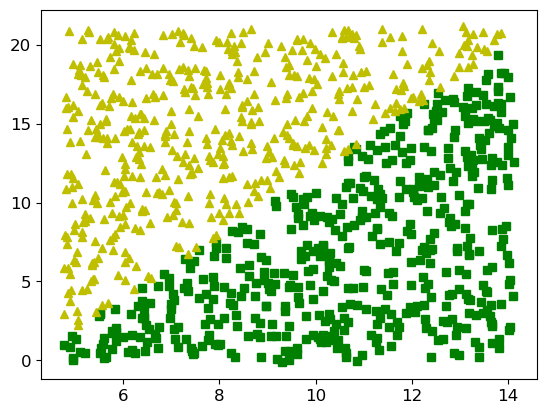

In [79]:
plt.plot(t[positive_class], X[positive_class, 1], 'gs')
plt.plot(t[~positive_class], X[~positive_class, 1], 'y^')

## 8.3 PCA
### 분산 보존

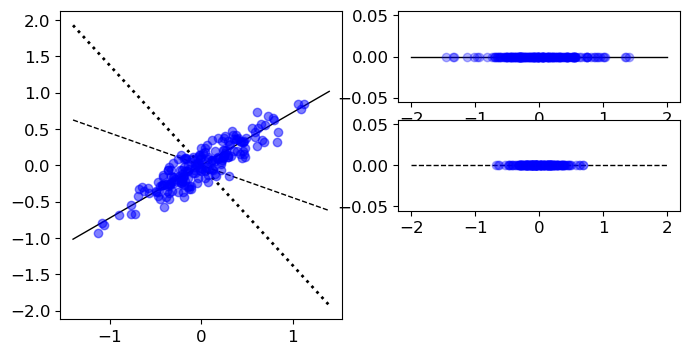

In [97]:
angle = np.pi / 5
stretch = 5
m = 200

np.random.seed(3)
X = np.random.randn(m, 2) / 10
X = X.dot(np.array([[stretch, 0], [0, 1]]))
X = X.dot([[np.cos(angle), np.sin(angle)], [-np.sin(angle), np.cos(angle)]])

u1 = np.array([np.cos(angle), np.sin(angle)])
u2 = np.array([np.cos(angle - 2 * np.pi / 6), np.sin(angle - 2 * np.pi / 6)])
u3 = np.array([np.cos(angle - np.pi/2), np.sin(angle - np.pi / 2)])

X_proj1 = X.dot(u1.reshape(-1, 1))
X_proj2 = X.dot(u2.reshape(-1, 1))
X_proj3 = X.dot(u3.reshape(-1, 1))

plt.figure(figsize=(8, 4))
plt.subplot2grid((3, 2), (0, 0), rowspan=3)
plt.plot([-1.4, 1.4], [-1.4 * u1[1] / u1[0], 1.4 * u1[1] / u1[0]], 'k-', linewidth=1)
plt.plot([-1.4, 1.4], [-1.4 * u2[1] / u2[0], 1.4 * u2[1] / u2[0]], 'k--', linewidth=1)
plt.plot([-1.4, 1.4], [-1.4 * u3[1] / u3[0], 1.4 * u3[1] / u3[0]], 'k:', linewidth=2)
plt.plot(X[:, 0], X[:, 1], 'bo', alpha=0.5)

plt.subplot2grid((3, 2), (0, 1))
plt.plot([-2, 2], [0, 0], 'k-', linewidth=1)
plt.plot(X_proj1[:, 0], np.zeros(m), 'bo', alpha=0.3)

plt.subplot2grid((3, 2), (1, 1))
plt.plot([-2, 2], [0, 0], 'k--', linewidth=1)
plt.plot(X_proj2[:, 0], np.zeros(m), 'bo', alpha=0.3)

In [86]:
X

array([[ 1.78862847e-01,  4.36509851e-02],
       [ 9.64974681e-03, -1.86349270e-01],
       [-2.77388203e-02, -3.54758979e-02],
       [-8.27414815e-03, -6.27000677e-02],
       [-4.38181690e-03, -4.77218030e-02],
       [-1.31386475e-01,  8.84622380e-02],
       [ 8.81318042e-02,  1.70957306e-01],
       [ 5.00336422e-03, -4.04677415e-02],
       [-5.45359948e-02, -1.54647732e-01],
       [ 9.82367434e-02, -1.10106763e-01],
       [-1.18504653e-01, -2.05649899e-02],
       [ 1.48614836e-01,  2.36716267e-02],
       [-1.02378514e-01, -7.12993200e-02],
       [ 6.25244966e-02, -1.60513363e-02],
       [-7.68836350e-02, -2.30030722e-02],
       [ 7.45056266e-02,  1.97611078e-01],
       [-1.24412333e-01, -6.26416911e-02],
       [-8.03766095e-02, -2.41908317e-01],
       [-9.23792022e-02, -1.02387576e-01],
       [ 1.12397796e-01, -1.31914233e-02],
       [-1.62328545e-01,  6.46675452e-02],
       [-3.56270759e-02, -1.74314104e-01],
       [-5.96649642e-02, -5.88594380e-02],
       [-8.

### 8.3.7 PCA 활용: MNIST 데이터 압축

In [98]:
from sklearn.datasets import fetch_openml

mnist = fetch_openml('mnist_784', version=1, as_frame=False)

/Users/taemin/anaconda3/lib/python3.10/site-packages/sklearn/datasets/_openml.py:932: FutureWarning: The default value of `parser` will change from `'liac-arff'` to `'auto'` in 1.4. You can set `parser='auto'` to silence this warning. Therefore, an `ImportError` will be raised from 1.4 if the dataset is dense and pandas is not installed. Note that the pandas parser may return different data types. See the Notes Section in fetch_openml's API doc for details.
  warn(


In [99]:
type(mnist)

sklearn.utils._bunch.Bunch

In [101]:
mnist.target = mnist.target.astype(np.uint8)

X = mnist['data']
y = mnist['target']

In [102]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y)

In [103]:
pca = PCA()
pca.fit(X_train)

PCA()

In [104]:
cumsum = np.cumsum(pca.explained_variance_ratio_)
d = np.argmax(cumsum >= 0.95) + 1
d

154

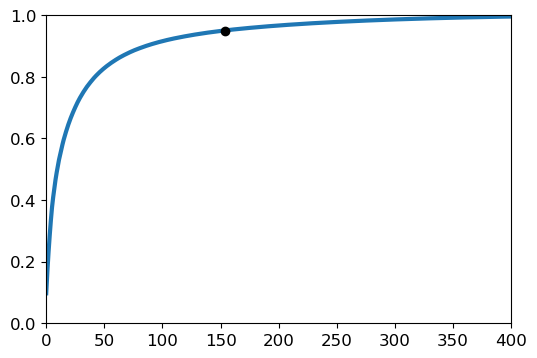

In [106]:
plt.figure(figsize=(6, 4))
plt.plot(cumsum, linewidth=3)

plt.axis([0, 400, 0, 1])
plt.plot(d, 0.95, 'ko')

In [107]:
pca = PCA(n_components=0.95)
X_reduced = pca.fit_transform(X_train)

In [108]:
pca.n_components_

154

In [109]:
np.sum(pca.explained_variance_ratio_)

0.9504334914295705

In [110]:
X_recovered = pca.inverse_transform(X_reduced)

np.mean(np.sum(np.square(X_recovered - X_train), axis=1))

169958.07288698855

In [111]:
pca = PCA(n_components=154)
X_reduced = pca.fit_transform(X_train)

X_recovered = pca.inverse_transform(X_reduced)

np.mean(np.sum(np.square(X_recovered - X_train), axis=1))

171385.92786831802

In [114]:
def plot_digits(instancees, images_per_row=5, **options):
    size = 28
    images_per_row = min(len(instancees), images_per_row)
    images = [instance.reshape(size, size) for instance in instancees]
    n_rows = (len(instancees) - 1) // images_per_row + 1
    row_images = []
    n_empty = n_rows * images_per_row - len(instancees)
    images.append(np.zeros((size, size * n_empty)))
    for row in range(n_rows):
        rimages = images[row * images_per_row: (row + 1) * images_per_row]
        row_images.append(np.concatenate(rimages, axis=1))
    image = np.concatenate(row_images, axis=0)
    plt.imshow(image, cmap=mpl.cm.binary, **options)
    plt.axis('off')


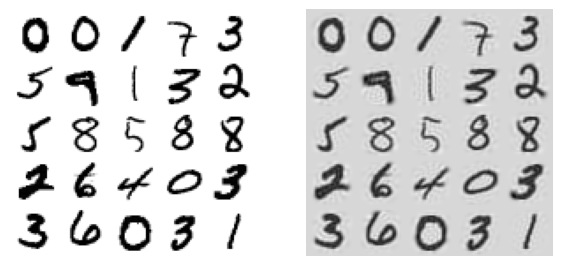

In [116]:
plt.figure(figsize=(7, 4))

plt.subplot(121)
plot_digits(X_train[::2100])

plt.subplot(122)
plot_digits(X_recovered[::2100])

In [117]:
X_reduced_pca = X_reduced

### 8.3.8 랜덤 PCA

In [118]:
rnd_pca = PCA(n_components=154, svd_solver='randomized', random_state=42)
X_reduced = rnd_pca.fit_transform(X_train)

### 8.3.9 점진적 PCA

In [119]:
from sklearn.decomposition import IncrementalPCA

n_batches = 100
inc_pca = IncrementalPCA(n_components=154)

for X_batch in np.array_split(X_train, n_batches):
    print('.', end='')
    inc_pca.partial_fit(X_batch)
    
X_reduced = inc_pca.transform(X_train)

....................................................................................................

In [120]:
batch_size = len(X_train) // n_batches

inc_pca_fit = IncrementalPCA(n_components=154, batch_size=batch_size)
X_reduced_fit = inc_pca_fit.fit_transform(X_train)

In [121]:
np.allclose(X_reduced, X_reduced_fit)

True

In [122]:
X_reduced_inc_pca = X_reduced

In [123]:
np.allclose(pca.mean_, inc_pca.mean_)

True

In [124]:
np.allclose(X_reduced_pca, X_reduced_inc_pca)

False

In [125]:
filename = 'my_mnist.data'
m, n = X_train.shape

X_mm = np.memmap(filename, dtype='float32', mode='write', shape=(m, n))
X_mm[:] = X_train

In [126]:
type(X_mm)

numpy.memmap

In [127]:
X_mm.shape

(52500, 784)

In [128]:
del X_mm

In [129]:
X_mm = np.memmap(filename, dtype='float32', mode='readonly', shape=(m, n))

## 8.4 커널 PCA

In [130]:
X, t = make_swiss_roll(n_samples=1000, noise=0.2, random_state=42)

In [131]:
from sklearn.decomposition import KernelPCA

rbf_pca = KernelPCA(n_components=2, kernel='rbf', gamma=0.04)
X_reduced = rbf_pca.fit_transform(X)

In [132]:
from sklearn.decomposition import KernelPCA

lin_pca = KernelPCA(n_components=2, kernel='linear', fit_inverse_transform=True)
rbf_pca = KernelPCA(n_components=2, kernel='rbf', gamma=0.0433, fit_inverse_transform=True)
sig_pca = KernelPCA(n_components=2, kernel='sigmoid', gamma=0.001, coef0=1, fit_inverse_transform=True)

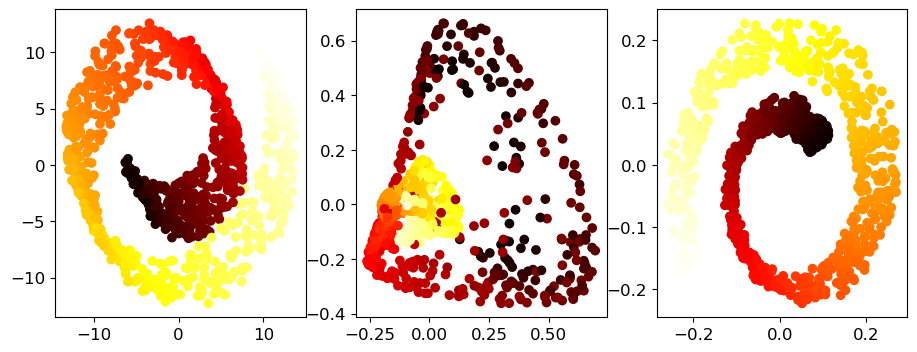

In [134]:
y = t > 6.9

plt.figure(figsize=(11, 4))
for subplot, pca, title in ((131, lin_pca, 'Linear kernel'), (132, rbf_pca, 'RBF kernel'), (133, sig_pca, 'Sigmoid kernel')):
    X_reduced = pca.fit_transform(X)
    if subplot == 132:
        X_reduced_rbf = X_reduced
        
    plt.subplot(subplot)
    plt.scatter(X_reduced[:, 0], X_reduced[:, 1], c=t, cmap=plt.cm.hot)

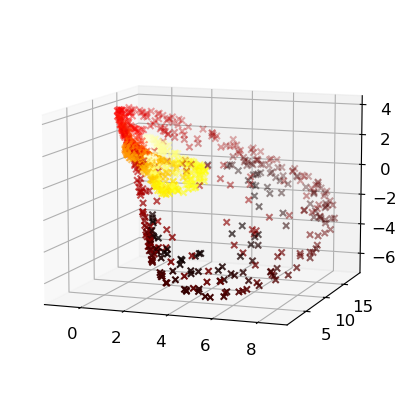

In [136]:
plt.figure(figsize=(6, 5))

X_inverse = rbf_pca.inverse_transform(X_reduced_rbf)

ax = plt.subplot(111, projection='3d')
ax.view_init(10, -70)
ax.scatter(X_inverse[:, 0], X_inverse[:, 1], X_inverse[:, 2], c=t, cmap=plt.cm.hot, marker='x')

### 8.4.1 커널 선택과 하이퍼파라미터 조정

In [137]:
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline

clf = Pipeline([
    ('kpca', KernelPCA(n_components=2)),
    ('log_reg', LogisticRegression(solver='lbfgs'))
])

param_grid = [{
    'kpca__gamma': np.linspace(0.03, 0.05, 10),
    'kpca__kernel': ['rbf', 'sigmoid']
}]

grid_search = GridSearchCV(clf, param_grid, cv=3)
grid_search.fit(X, y)

GridSearchCV(cv=3,
             estimator=Pipeline(steps=[('kpca', KernelPCA(n_components=2)),
                                       ('log_reg', LogisticRegression())]),
             param_grid=[{'kpca__gamma': array([0.03      , 0.03222222, 0.03444444, 0.03666667, 0.03888889,
       0.04111111, 0.04333333, 0.04555556, 0.04777778, 0.05      ]),
                          'kpca__kernel': ['rbf', 'sigmoid']}])

In [138]:
print(grid_search.best_params_)

{'kpca__gamma': 0.043333333333333335, 'kpca__kernel': 'rbf'}


In [139]:
rbf_pca = KernelPCA(n_components=2, kernel='rbf', gamma=0.0433,
                    fit_inverse_transform=True)
X_reduced = rbf_pca.fit_transform(X)

X_preimage = rbf_pca.inverse_transform(X_reduced)

In [140]:
from sklearn.metrics import mean_squared_error

mean_squared_error(X, X_preimage)

32.78630879576611

## 연습문제
### 9

In [141]:
X_train = mnist['data'][:60000]
y_train = mnist['target'][:60000]

X_test = mnist['data'][60000:]
y_test = mnist['target'][60000:]

In [142]:
from sklearn.ensemble import RandomForestClassifier

rnd_clf = RandomForestClassifier(n_estimators=100, random_state=42)

In [143]:
import time

t0 = time.time()
rnd_clf.fit(X_train, y_train)
t1 = time.time()

In [144]:
print('Traning took {:.2f}s'.format(t1 - t0))

Traning took 27.85s


In [145]:
from sklearn.metrics import accuracy_score

y_pred = rnd_clf.predict(X_test)
accuracy_score(y_test, y_pred)

0.9691

In [146]:
from sklearn.decomposition import PCA

pca = PCA(n_components=0.95)
X_train_reduced = pca.fit_transform(X_train)

In [147]:
rnd_clf2 = RandomForestClassifier(n_estimators=100, random_state=42)
t0 = time.time()
rnd_clf2.fit(X_train_reduced, y_train)
t1 = time.time()

In [148]:
print("Training took {:.2f}s".format(t1 - t0))

Training took 77.95s


In [149]:
X_test_reduced = pca.transform(X_test)

y_pred = rnd_clf2.predict(X_test_reduced)
accuracy_score(y_test, y_pred)

0.9474

In [150]:
from sklearn.linear_model import LogisticRegression

log_clf = LogisticRegression(multi_class='multinomial', solver='lbfgs', random_state=42)
t0 = time.time()
log_clf.fit(X_train, y_train)
t1 = time.time()

/Users/taemin/anaconda3/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [151]:
print('Training took {:.2f}s'.format(t1 - t0))

Training took 40.87s


In [152]:
y_pred = log_clf.predict(X_test)
accuracy_score(y_test, y_pred)

0.9255

In [153]:
log_clf2 = LogisticRegression(multi_class='multinomial', solver='lbfgs', random_state=42)
t0 = time.time()
log_clf2.fit(X_train_reduced, y_train)
t1 = time.time()

/Users/taemin/anaconda3/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [154]:
print("Training took {:.2f}s".format(t1 - t0))

Training took 16.26s


In [155]:
y_pred = log_clf2.predict(X_test_reduced)
accuracy_score(y_test, y_pred)

0.9201

### 10

In [157]:
np.random.seed(42)

m = 10000
idx = np.random.permutation(60000)[:m]

X = mnist['data'][idx]
y = mnist['target'][idx]

In [158]:
from sklearn.manifold import TSNE

tsne = TSNE(n_components=2, random_state=42)
X_reduced = tsne.fit_transform(X)

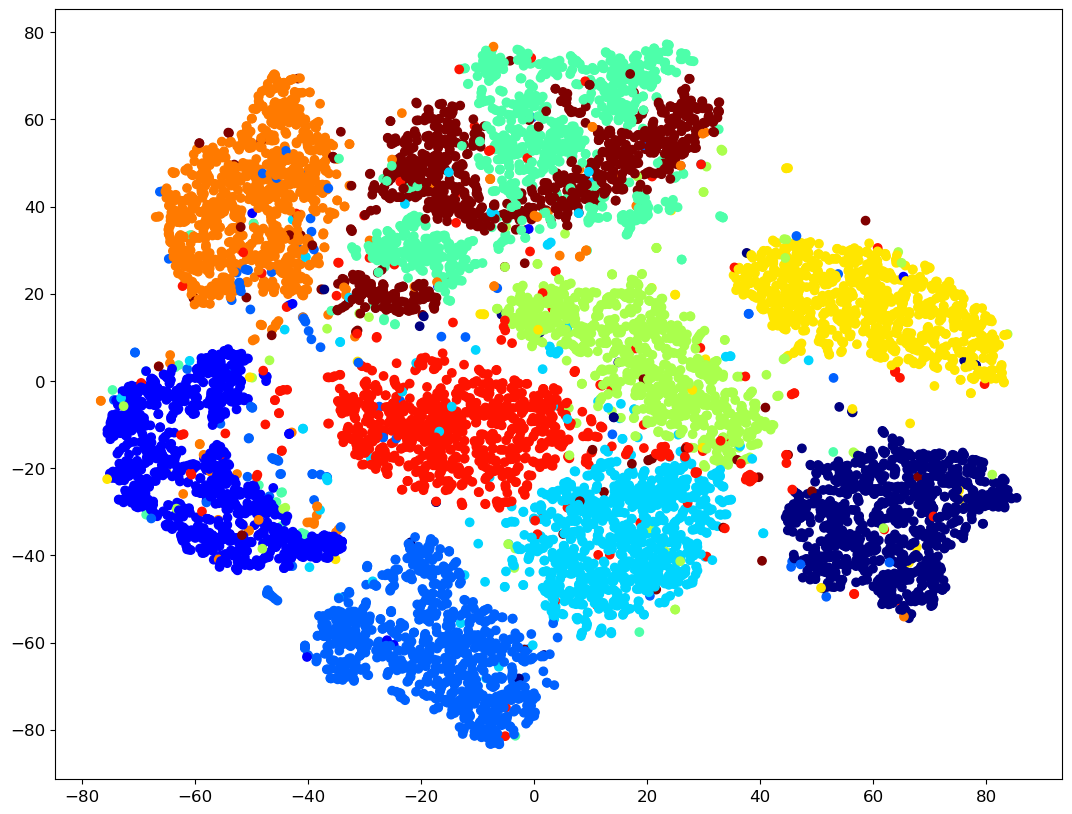

In [159]:
plt.figure(figsize=(13, 10))
plt.scatter(X_reduced[:, 0], X_reduced[:, 1], c=y, cmap='jet')

/var/folders/j_/hylrqd052y9czkfmjyyc7n7r0000gn/T/ipykernel_71619/281953689.py:2: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = mpl.cm.get_cmap('jet')


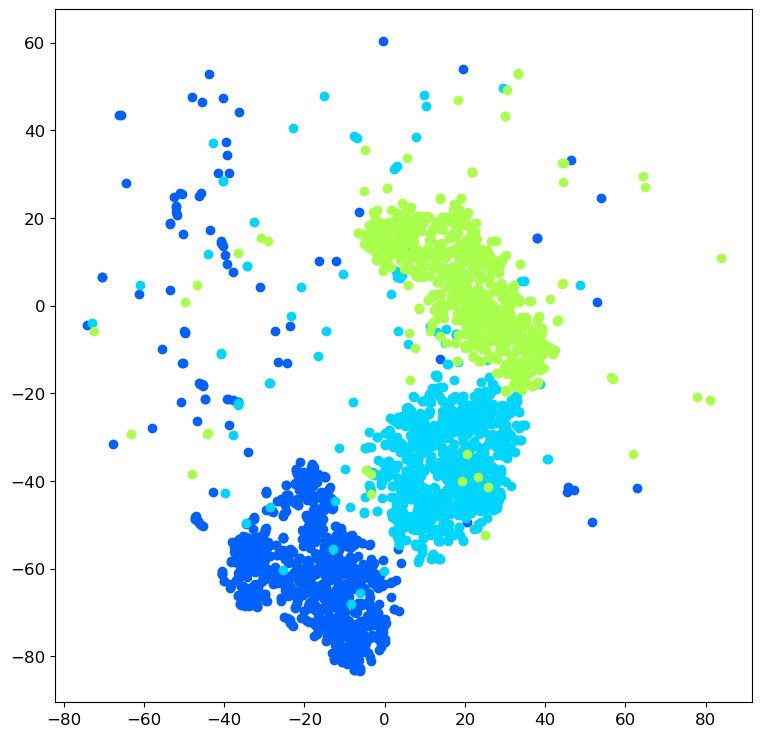

In [160]:
plt.figure(figsize=(9, 9))
cmap = mpl.cm.get_cmap('jet')
for digit in (2,3,5):
    plt.scatter(X_reduced[y == digit, 0], X_reduced[y == digit, 1], c=[cmap(digit / 9)])

In [161]:
idx = (y == 2) | (y == 3) | (y == 5)
X_subset = X[idx]
y_subset = y[idx]

tsne_subset = TSNE(n_components=2, random_state=42)
X_subset_reduced = tsne_subset.fit_transform(X_subset)

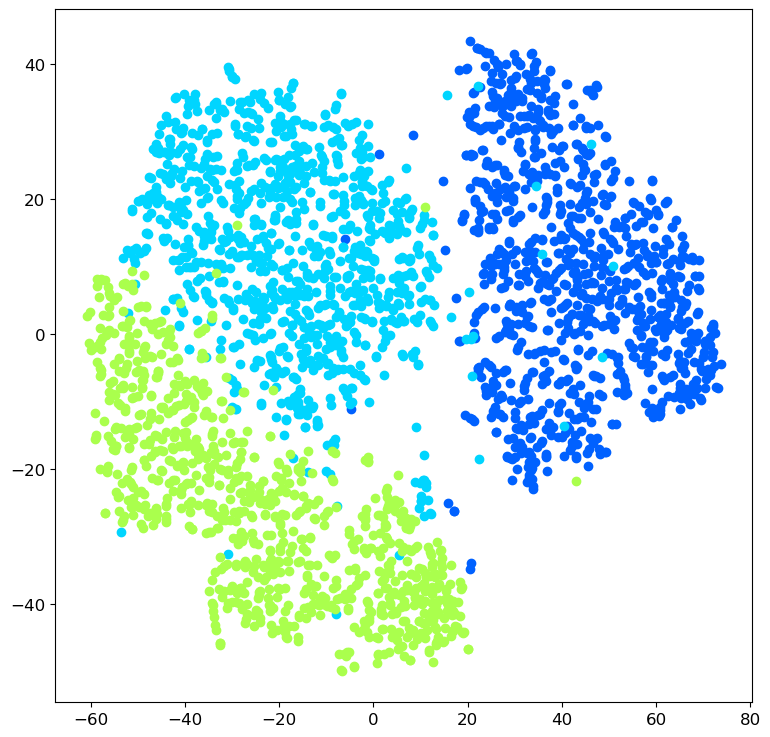

In [162]:
plt.figure(figsize=(9, 9))
for digit in (2,3,5):
    plt.scatter(X_subset_reduced[y_subset == digit, 0], X_subset_reduced[y_subset == digit, 1], c=[cmap(digit / 9)])